# Problem 2

## Option Pricing through Monte Carlo

### Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import qmc
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from scipy.interpolate import griddata

# Parameters
M = 1000 # Num of simulations in MC
T = 0.25
dt = 1 / (2 * 366) # 2 time steps per day
beta0 = 0.08
beta1 = -0.08
beta2 = 0.5
lambda1 = 62.0
lambda2 = 40.0
R1_init = -0.044
R2_init = 0.007
r = 0.05

# Number of time steps (N * dt = T)
N = int(np.round(T / dt))

### Option Payoff

In [2]:
# Put option payoff discounted
# S is a matrix of stock price w.r.t. time
def put_payoff(r,T,K,S):
    # Terminal stock price
    S_T = S[:,-1]
    return np.exp(-r * T) * np.maximum(K - S_T,0)

### Volatility Function

In [3]:
# Volatility function in the model
def sigma(R1,R2,beta0,beta1,beta2):
    return beta0 + beta1 * R1 + beta2 * np.sqrt(R2)

### Monte Carlo

In [4]:
# This function prepares M samples by Monte Carlo, each sample is an
# estimated put price based on that trajectory. Notice that the function 
# requires inputting BM increments as a matrix of size M * N
def MC_sample(M,N,dt,T,K,lambda1,lambda2,r,
              beta0,beta1,beta2,W_incr,R1_init,R2_init,S0):
    # Check if W_incr has M rows and N columns
    if W_incr.shape[0] != M or W_incr.shape[1] != N:
        return 0
    
    # Vectorize Monte Carlo
    S = np.zeros((M,N + 1))
    R1 = np.zeros((M,N + 1))
    R2 = np.zeros((M,N + 1))
    S[:,0] = S0 * np.ones(M)
    R1[:,0] = R1_init * np.ones(M)
    R2[:,0] = R2_init * np.ones(M)
    
    for i in range(1,N + 1):
        # Calculate sigma function once
        sigma_vec = sigma(R1[:,i - 1],R2[:,i - 1],beta0,beta1,beta2)
            
        # Euler scheme
        S[:,i] = S[:,i - 1] + S[:,i - 1] * sigma_vec * W_incr[:,i - 1]
            
        R1[:,i] = R1[:,i - 1] + lambda1 * sigma_vec * W_incr[:,i - 1] \
                    - lambda1 * R1[:,i - 1] * dt
            
        R2[:,i] = np.maximum(R2[:,i - 1] + lambda2 * (sigma_vec ** 2 \
                                        - R2[:,i - 1]) * dt,0)
            
    # Take average as estimate of put price
    price_lst = put_payoff(r,T,K,S)
        
    return price_lst

### Test the Function for Option Pricing

In [5]:
# Build up BM increments
W_incr = np.sqrt(dt) * np.random.randn(M,N)
S0 = 10.0
K = 10.0
price_lst = MC_sample(M,N,dt,T,K,lambda1,lambda2,r,
                      beta0,beta1,beta2,W_incr,R1_init,R2_init,S0)
price_est = np.mean(price_lst)
print(price_est)

0.3345758349665816


### Plot the Relationship between Initial Stock Price and Option Price

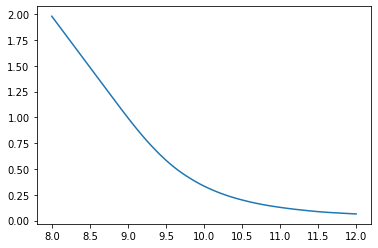

In [6]:
S0_lst = np.linspace(8,12,100)
K = 10.0
price_est_lst = []
for S0 in S0_lst:
    price_lst = MC_sample(M,N,dt,T,K,lambda1,lambda2,r,
                      beta0,beta1,beta2,W_incr,R1_init,R2_init,S0)
    price_est = np.mean(price_lst)
    price_est_lst.append(price_est)
plt.plot(S0_lst,price_est_lst)

## Bump-and-revalue estimation of Delta

Text(0.5, 1.0, 'Bump-and-revalue Method')

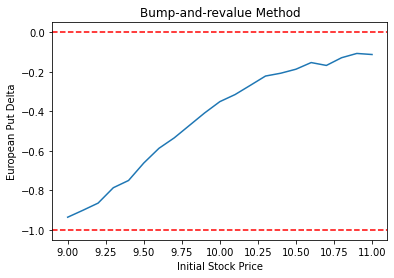

In [7]:
# A list of initial stock price
S0_lst = np.linspace(9,11,21)
K = 10.0

# Bump size
eps = 0.005

# Record option Delta
bump_Delta_lst = []

for S0 in S0_lst:
    # Build up BM increments
    W_incr = np.sqrt(dt) * np.random.randn(M,N)
    
    # Get option price for S0 \pm eps (same BM trajectories)
    S0_up = S0 + eps
    price_lst_up = MC_sample(M,N,dt,T,K,lambda1,lambda2,r,
                      beta0,beta1,beta2,W_incr,R1_init,R2_init,S0_up)
    S0_down = S0 - eps
    price_lst_down = MC_sample(M,N,dt,T,K,lambda1,lambda2,r,
                      beta0,beta1,beta2,W_incr,R1_init,R2_init,S0_down)
    
    # Calculate Delta for all trajectories
    Delta_est_lst = (np.array(price_lst_up) - np.array(price_lst_down))\
                    / (2 * eps)
    
    # Take average as estimate
    Delta_est = np.mean(Delta_est_lst)
    bump_Delta_lst.append(Delta_est)
    
# Plot the Delta curve and two horizontal lines
plt.plot(S0_lst,bump_Delta_lst)
plt.axhline(y = 0.0, color='r', linestyle='dashed')
plt.axhline(y = -1.0, color='r', linestyle='dashed')
plt.xlabel('Initial Stock Price')
plt.ylabel('European Put Delta')
plt.title('Bump-and-revalue Method')

## Gaussian Process Surrogate

### Prepare training samples

In [8]:
# Prepare training samples for a list of initial stock price
# Return a list whose rows are training samples
def gen_training_sample(M,N,dt,T,K,lambda1,lambda2,r,
              beta0,beta1,beta2,W_incr,R1_init,R2_init,S0_lst):
    
    train_sample = []
    for S0 in S0_lst:
        # Build up BM increments
        W_incr = np.sqrt(dt) * np.random.randn(M,N)
        
        # Monte Carlo
        price_lst = MC_sample(M,N,dt,T,K,lambda1,lambda2,r,
              beta0,beta1,beta2,W_incr,R1_init,R2_init,S0)
        
        # Take average as estimation of put price
        price_est = np.mean(price_lst)
        
        # Record
        train_sample.append([S0,price_est])
    return train_sample

### GP Regression

In [9]:
K = 10.0
# Add boundary training samples
S0_lst = np.array(list(np.linspace(9,11,21)) + list(np.linspace(8.8,8.95,5))\
                 + list(np.linspace(11.05,11.2,5)))

# Get training samples
train_sample = gen_training_sample(M,N,dt,T,K,lambda1,lambda2,r,
              beta0,beta1,beta2,W_incr,R1_init,R2_init,S0_lst)
train_sample = np.array(train_sample)

# Split the train sample and standardize option price
opt_price_mean = np.mean(train_sample[:,1])
opt_price_stddev = np.std(train_sample[:,1])
features = train_sample[:,0].reshape(-1,1)
opt_price = train_sample[:,1]
std_opt_price = (opt_price - opt_price_mean) / opt_price_stddev

# Specify the kernel with optimized lengthscale
my_kernel_matern = Matern(nu = 2.5)

# alpha as the variance of the error, a hyperparameter (tuned)
gpr = GaussianProcessRegressor(kernel = my_kernel_matern,alpha = 1e-2)
gpr.fit(features,std_opt_price)

GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=1, nu=2.5))

### Test GP Surrogate

When S0 is 10, put price is 0.33363173141324354


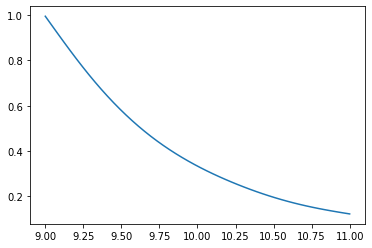

In [10]:
# Prediction when initial stock price is 10
std_opt_price_pred = gpr.predict([[10]])[0]
opt_price_pred = std_opt_price_pred * opt_price_stddev + opt_price_mean
print('When S0 is 10, put price is ' + str(opt_price_pred))

# Plot GP
plot_S0 = np.linspace(9,11,50)
std_opt_price_pred = gpr.predict(plot_S0.reshape(-1,1))
opt_price_pred = std_opt_price_pred * opt_price_stddev + opt_price_mean
plt.plot(plot_S0,opt_price_pred)

### Bump-and-revalue with GP

Text(0.5, 1.0, 'Bump-and-revalue Method with GP')

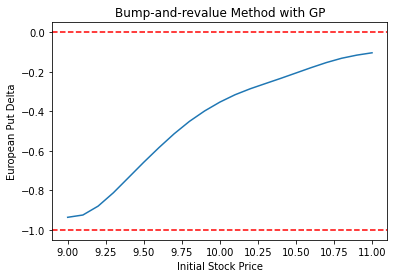

In [11]:
# A list of initial stock price
S0_lst = np.linspace(9,11,21)

# Bump size
eps = 0.005

# Record option Delta
GP_bump_Delta_lst = []

for S0 in S0_lst:
    # Bump
    S0_up = S0 + eps
    S0_down = S0 - eps
    
    # Prediction based on GP
    std_opt_price_pred = gpr.predict(np.array([S0_up,S0_down]).reshape(-1,1))
    
    # Recover from standardization
    opt_price_pred = std_opt_price_pred * opt_price_stddev + opt_price_mean
    
    Delta_est = (opt_price_pred[0] - opt_price_pred[1]) / (2 * eps)
    GP_bump_Delta_lst.append(Delta_est)
    
# Plot the curve
plt.plot(S0_lst,GP_bump_Delta_lst)
plt.axhline(y = 0.0, color='r', linestyle='dashed')
plt.axhline(y = -1.0, color='r', linestyle='dashed')
plt.xlabel('Initial Stock Price')
plt.ylabel('European Put Delta')
plt.title('Bump-and-revalue Method with GP')

## Neural Network

In [12]:
import torch
from torch import nn

# Sigmoid activation
class Sigmoid_Model(nn.Module):
    # Standard feedforward NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(1,30),   # 3-layer, hidden layer of dimension 32
            nn.Sigmoid(),      
            nn.Linear(30, 30), 
            nn.Sigmoid(),      
            nn.Linear(30, 1),  
            )
    def forward(self,z):
        return self.net(z)

# ReLU activation
class ReLU_Model(nn.Module):
    # Standard feedforward NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(1,30),   # 3-layer, hidden layer of dimension 32
            nn.ReLU(),      
            nn.Linear(30, 30), 
            nn.ReLU(),      
            nn.Linear(30, 1),  
            )
    def forward(self,z):
        return self.net(z)

# Tanh activation
class Tanh_Model(nn.Module):
    # Standard feedforward NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(1,30),   # 3-layer, hidden layer of dimension 32
            nn.Tanh(),      
            nn.Linear(30, 30), 
            nn.Tanh(),      
            nn.Linear(30, 1),  
            )
    def forward(self,z):
        return self.net(z)
    
# ELU activation
class ELU_Model(nn.Module):
    # Standard feedforward NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(1,30),   # 3-layer, hidden layer of dimension 32
            nn.ELU(),      
            nn.Linear(30, 30), 
            nn.ELU(),      
            nn.Linear(30, 1),  
            )
    def forward(self,z):
        return self.net(z)

### Prepare a lot of training samples

In [13]:
# Step size as fine as possible
K = 10.0
S0_lst = np.linspace(8.8,11.2,1000)
all_train_sample = gen_training_sample(M,N,dt,T,K,lambda1,lambda2,r,
                  beta0,beta1,beta2,W_incr,R1_init,R2_init,S0_lst)

### Training Function

In [14]:
# Train the NN with a particular activation function
# lr_eta as learning rate, return a trained NN object
def train_NN(M,N,dt,T,K,lambda1,lambda2,r,beta0,beta1,beta2,W_incr,
             R1_init,R2_init,Model,N_epoch,lr_eta,all_sample):
    # Build NN object and optimizer
    NN = Model()
    opt = torch.optim.Adam(NN.parameters(),lr = lr_eta)
    
    # Within each epoch
    for epoch_ind in range(N_epoch):
        # Randomly choose some training samples from all_sample
        train_sample = torch.Tensor(all_sample)
        sample_size = len(all_sample)
        
        # Split the feature and option price
        features = train_sample[:,0].reshape(-1,1)
        opt_price = train_sample[:,1]
        
        # Send into NN and get the loss
        NN_output = NN(features)
        NN_output = torch.squeeze(NN_output)
        loss = 1 / (2 * sample_size) * torch.sum((NN_output - opt_price) ** 2)
        if epoch_ind % 1000 == 0: print('loss: ' + str(float(loss.detach())))
        
        # Back propagation and update parameters
        loss.backward()
        opt.step()
        opt.zero_grad()
    return NN

### Sigmoid Activation

loss: 0.0773024931550026
loss: 0.00045813198084942997
loss: 0.00036098051350563765
loss: 0.00026377002359367907
loss: 0.0005583667079918087
loss: 0.00033158392761833966
loss: 0.0004986062413081527
loss: 0.0005059281829744577
loss: 0.0007429129327647388
loss: 0.00033477775286883116


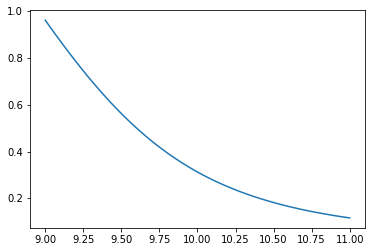

In [15]:
# Train NN
N_epoch = 10000
lr_eta = 0.05
Model = Sigmoid_Model
Sigmoid_NN = train_NN(M,N,dt,T,K,lambda1,lambda2,r,beta0,beta1,beta2,W_incr,
             R1_init,R2_init,Model,N_epoch,lr_eta,all_train_sample)

# Plot the option price curve
S0_plot = torch.linspace(9,11,100)
NN_pred_price = torch.squeeze(Sigmoid_NN(S0_plot.reshape(-1,1)))
plt.plot(S0_plot.detach(),NN_pred_price.detach())

In [16]:
# A function to plot Delta based on NN
# Return the lists for plotting
def plot_Delta(NN):
    # Get option Delta as the gradient of output w.r.t. initial stock price
    S0_plot = np.linspace(9,11,100)
    Delta_lst = []
    for S0 in S0_plot:
        S0 = torch.Tensor(np.array([S0]))
        S0 = torch.unsqueeze(S0,1)
        S0.requires_grad = True
        NN_pred_price = torch.squeeze(NN(S0))
        NN_pred_price.backward()
        # Get gradient of option price w.r.t. initial stock price
        Delta_lst.append(S0.grad.detach())
    # Plot Delta curve
    plt.plot(S0_plot,Delta_lst)
    plt.axhline(y = 0.0, color='r', linestyle='dashed')
    plt.axhline(y = -1.0, color='r', linestyle='dashed')
    plt.xlabel('Initial Stock Price')
    plt.ylabel('European Put Delta')
    plt.title('NN Estimation')
    return S0_plot,Delta_lst

/Users/a24395/Library/Python/3.8/lib/python/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/a24395/Library/Python/3.8/lib/python/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


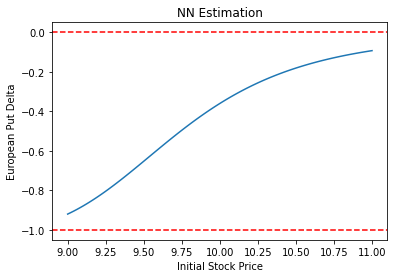

In [17]:
S0_plot,Sigmoid_Delta_lst = plot_Delta(Sigmoid_NN)

### ReLU Activation

loss: 0.06083538383245468
loss: 0.00047912434092722833
loss: 0.0003903576289303601
loss: 0.0003187882830388844
loss: 0.002031290903687477
loss: 0.00044673809316009283
loss: 0.00028290433692745864
loss: 0.00028367043705657125
loss: 0.00048752030124887824
loss: 0.0002845357230398804


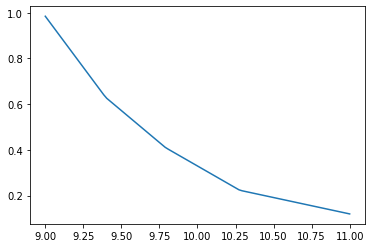

In [18]:
# Train NN
N_epoch = 10000
lr_eta = 0.005
Model = ReLU_Model
ReLU_NN = train_NN(M,N,dt,T,K,lambda1,lambda2,r,beta0,beta1,beta2,W_incr,
             R1_init,R2_init,Model,N_epoch,lr_eta,all_train_sample)

# Plot the option price curve
S0_plot = torch.linspace(9,11,100)
NN_pred_price = torch.squeeze(ReLU_NN(S0_plot.reshape(-1,1)))
plt.plot(S0_plot.detach(),NN_pred_price.detach())

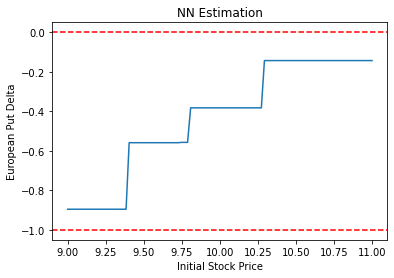

In [19]:
S0_plot,ReLU_Delta_lst = plot_Delta(ReLU_NN)

### Tanh Activation

loss: 0.2474435269832611
loss: 0.0003143915964756161
loss: 0.00025152359739877284
loss: 0.00034163292730227113
loss: 0.0002826566051226109
loss: 0.0002504542062524706
loss: 0.00046455609844997525
loss: 0.00034661515383049846
loss: 0.00029153472860343754
loss: 0.00039453915087506175


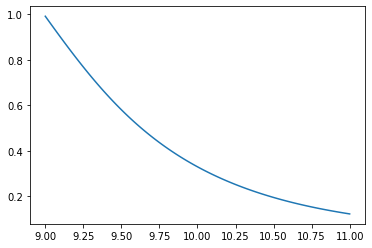

In [20]:
# Train NN
N_epoch = 10000
lr_eta = 0.01
Model = Tanh_Model
Tanh_NN = train_NN(M,N,dt,T,K,lambda1,lambda2,r,beta0,beta1,beta2,W_incr,
             R1_init,R2_init,Model,N_epoch,lr_eta,all_train_sample)

# Plot the option price curve
S0_plot = torch.linspace(9,11,100)
NN_pred_price = torch.squeeze(Tanh_NN(S0_plot.reshape(-1,1)))
plt.plot(S0_plot.detach(),NN_pred_price.detach())

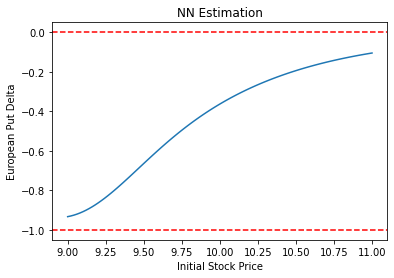

In [21]:
S0_plot,Tanh_Delta_lst = plot_Delta(Tanh_NN)

### ELU Activation

loss: 0.0596342496573925
loss: 0.0002962805447168648
loss: 0.00028886040672659874
loss: 0.0002857712097465992
loss: 0.00028282959829084575
loss: 0.0002795127220451832
loss: 0.00027642963686957955
loss: 0.0002741374773904681
loss: 0.0008976284880191088
loss: 0.00027464423328638077


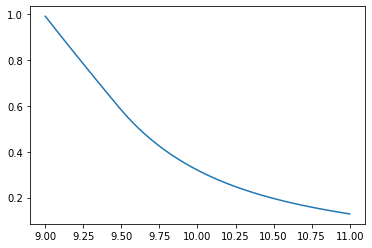

In [22]:
# Train NN
N_epoch = 10000
lr_eta = 0.01
Model = ELU_Model
ELU_NN = train_NN(M,N,dt,T,K,lambda1,lambda2,r,beta0,beta1,beta2,W_incr,
             R1_init,R2_init,Model,N_epoch,lr_eta,all_train_sample)

# Plot the option price curve
S0_plot = torch.linspace(9,11,100)
NN_pred_price = torch.squeeze(ELU_NN(S0_plot.reshape(-1,1)))
plt.plot(S0_plot.detach(),NN_pred_price.detach())

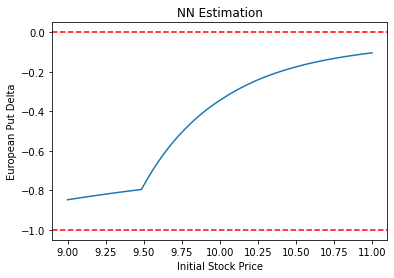

In [23]:
S0_plot,ELU_Delta_lst = plot_Delta(ELU_NN)

## Compare Delta Curves in One Plot

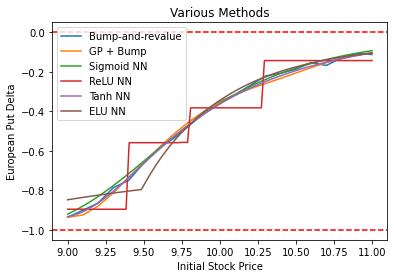

In [24]:
# Bump-and-revalue
bump_S0_lst = np.linspace(9,11,21)
plt.plot(bump_S0_lst,bump_Delta_lst,label = 'Bump-and-revalue')

# GP + bump
plt.plot(bump_S0_lst,GP_bump_Delta_lst,label = 'GP + Bump')

# Various NN
plt.plot(S0_plot,Sigmoid_Delta_lst,label = 'Sigmoid NN')
plt.plot(S0_plot,ReLU_Delta_lst,label = 'ReLU NN')
plt.plot(S0_plot,Tanh_Delta_lst,label = 'Tanh NN')
plt.plot(S0_plot,ELU_Delta_lst,label = 'ELU NN')

# Other lines
plt.axhline(y = 0.0, color='r', linestyle='dashed')
plt.axhline(y = -1.0, color='r', linestyle='dashed')
plt.xlabel('Initial Stock Price')
plt.ylabel('European Put Delta')
plt.title('Various Methods')
plt.legend()